<a href="https://github.com/mauropv/RFID-Fingerprint2020/blob/master/RFID_RFP_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# The Tags Are Alright: Robust Large-Scale RFID Clone Detection Through Federated Data-Augmented Radio Fingerprinting  
## Authors: Mauro Piva<sup>1</sup>, Gaia Maselli<sup>1</sup>, Francesco Restuccia<sup>2</sup>  
### <sup>1</sup>Department of Computer Science, Sapienza University, Italy
### <sup>2</sup>Department of Electrical and Computer Engineering, Northeastern University, United States  

# Notebook Description

  
This code is used to demonstrate our recent paper and to offer some example on ho to manage the related dataset.  

Please select an environment with a GPU available

Open this folder with google drive: https://drive.google.com/drive/folders/1l7cvR1Z8V7eiVdqcPgv0i5rb2ZMSja63?usp=sharing

Click on add shortcut to my drive

In [ ]:
#Importing Dataframe
from google.colab import drive
drive.mount('/content/drive')


import os
PATH_TRAIN = '/content/drive/My Drive/Public-RFID2020-RFP-Dataset/preprocessed/FILT-train/'
PATH_VALID = '/content/drive/My Drive/Public-RFID2020-RFP-Dataset/preprocessed/FILT-validation/'
PATH_TEST = "/content/drive/My Drive/Public-RFID2020-RFP-Dataset/preprocessed/FILT-test/"
PATH_MODELS = "/tmp/"
PATH_RESULTS = "/tmp/"
os.path.isdir(PATH_TRAIN)    # False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


True

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
np.set_printoptions(suppress=True)
np.random.seed(1)
import torch.optim as optim
from torchsummary import summary
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#Parameters
num_tags = 20
perc_to_load = 0.1
additive_id = 0
batch_size = 64

In [ ]:
def load_data_split(root_path, start, end, first_id, last_id, letts,additive_id):
    wave_piece_size = 1024#3072# 1024
    X, y = [], []
    for raw_signal_file in os.listdir(root_path):
        
        tag_id = raw_signal_file[5:8]
        tag_let = raw_signal_file[8]
        if (tag_let not in letts or first_id > int(tag_id) or last_id <= int(tag_id)):
            continue
        print(raw_signal_file)
        signal_loaded = np.load(open(root_path + raw_signal_file, "rb"))
        for wave_id in range(int(len(signal_loaded) * start), int(len(signal_loaded) * end)):
            wave = signal_loaded[wave_id]
            for i in range(0, len(wave) - wave_piece_size, 256):
                x_tmp = np.asarray(wave[i:i + wave_piece_size])
                X += [x_tmp]
                y += [int(tag_id)-additive_id]
    return X, y

In [ ]:
kernel_size = 3

a0 = nn.Conv1d(in_channels= 2, out_channels= 25, kernel_size= 3, padding = (kernel_size // 2))
a1 = nn.LeakyReLU(negative_slope=0.1)
b0 = nn.MaxPool1d(kernel_size = 2, padding = 1)

c0 = nn.Conv1d(in_channels= 25, out_channels= 25, kernel_size= 3, padding = (kernel_size // 2))
c1 = nn.LeakyReLU(negative_slope=0.1)
d0 = nn.MaxPool1d(2, padding = 1)

e0 = nn.Flatten()   
e1 = nn.Linear(6425,num_tags)

model = nn.Sequential(a0,a1,b0,c0,c1,d0,e0,e1)
criterion = nn.CrossEntropyLoss()

def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

summary(model.cuda(),(2,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 25, 1024]             175
         LeakyReLU-2             [-1, 25, 1024]               0
         MaxPool1d-3              [-1, 25, 513]               0
            Conv1d-4              [-1, 25, 513]           1,900
         LeakyReLU-5              [-1, 25, 513]               0
         MaxPool1d-6              [-1, 25, 257]               0
           Flatten-7                 [-1, 6425]               0
            Linear-8                   [-1, 20]         128,520
Total params: 130,595
Trainable params: 130,595
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.78
Params size (MB): 0.50
Estimated Total Size (MB): 1.29
----------------------------------------------------------------


In [ ]:
def client_update(client_model, optimizer, train_loader, epoch):
    """
    This function updates/trains client model on client data
    """
    client_model.train()
    accs = []
    for e in range(epoch):
        running_accuracy = 0.
        l = len((train_loader))
        for batch_idx, (data, target) in enumerate(train_loader):
            #print(batch_idx, l)
            #data, target = augment(data, target)
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()

            output = client_model(data)
            loss = criterion(output, target.long())

            #loss = F.nll_loss(output, target.long())
            loss.backward()
            optimizer.step()
            running_accuracy += accuracy(output, target)/len(train_loader)
        print(str(running_accuracy.cpu().numpy()))
        accs.append(running_accuracy.cpu().numpy())
        #print(accs)

    return loss.item(), accs

def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
      global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for m in client_models:
      m.load_state_dict(global_model.state_dict())
    
def test(testing_model, testing_loader):
    
    """This function test the global model on test data and returns test loss and test accuracy """
    testing_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testing_loader:
            data, target = data.cuda(), target.cuda()#data, target#data.cuda(), target.cuda()
            output = testing_model(data)
            test_loss += F.nll_loss(output, target.long(), reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testing_loader.dataset)
    acc = correct / len(testing_loader.dataset)
    del testing_model

    return test_loss, acc

In [ ]:
def augment(data, target):
    pitch = [5,10,20,100]
    data_ret, target_ret = data.clone(), target.clone()
    means = data.mean(axis = 2)
    for p in pitch:
        gc.collect()
        dr,tr = data.clone(), target.clone()
        i = -1
        for tensor in dr:
            i += 1
            tensor[:,0] = tensor[:,0].add(torch.normal(0, abs(means[i][0]/p), size=(1, data.shape[1])))
            tensor[:,1] = tensor[:,1].add(torch.normal(0, abs(means[i][1]/p), size=(1, data.shape[1])))
        data_ret = torch.cat((data_ret, dr), dim = 0)
        target_ret = torch.cat((target_ret, tr), dim = 0)
    return data_ret, target_ret

In [ ]:
# Parameters
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 4}

def generaTrainSet(lettera):
    X, y = load_data_split(PATH_TRAIN, 0, perc_to_load, additive_id, additive_id+num_tags, lettera,0)
    X_train = torch.from_numpy(np.asarray(X)).float()
    X_train = X_train.transpose(1, 2).contiguous()
    y_train = torch.from_numpy(np.asarray(y))
    #X_train, y_train = augment(X_train, y_train)
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    training_generator = torch.utils.data.DataLoader(dataset, **params)
    return training_generator

train_loader = [generaTrainSet("A"),generaTrainSet("B"),generaTrainSet("C")]

In [ ]:
Xt, yt = load_data_split(PATH_VALID, 0, 1, additive_id, additive_id+num_tags, "ABC",0)


X_test = torch.from_numpy(np.asarray(Xt)).float()
X_test = X_test.transpose(1, 2).contiguous()
y_test = torch.from_numpy(np.asarray(yt))
dataset_t = torch.utils.data.TensorDataset(X_test, y_test)


# Parameters
params = {'batch_size': batch_size,
          'shuffle': True}



test_generator = torch.utils.data.DataLoader(dataset_t, **params)
test_loader = test_generator

In [ ]:
num_clients = 3
num_selected =3
num_rounds = 100
epochs = 1

global_model =  copy.deepcopy(model).cuda()

client_models = [ copy.deepcopy(model).cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

opt = [optim.Adam(model.parameters()) for model in client_models]

In [ ]:
losses_train = []
losses_test = []
acc_train = []
acc_test = []

accs_tot = [[],[],[]]

for r in range(num_rounds):
    client_idx = np.random.permutation(num_clients)[:num_selected]
    loss = 0
    for i in range(num_selected):
        print("CLI",client_idx[i])
        l, accs = client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
        loss += l
        for a in accs:
            accs_tot[client_idx[i]].append(a)
 
    losses_train.append(loss)
    server_aggregate(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))

#print(accs_tot)

CLI 0
0.99016565
CLI 2
0.9611273
CLI 1
0.9873359
0-th round
average train loss 30.2 | test loss 320 | test acc: 0.561
CLI 2
0.9572907
CLI 1
0.98544306
CLI 0
0.9864729
1-th round
average train loss 43.7 | test loss -396 | test acc: 0.559
CLI 2
0.96430755
CLI 1
0.984703
CLI 0
0.99312747
2-th round
average train loss 0 | test loss -113 | test acc: 0.563
CLI 2
0.95794624
CLI 1
0.9888178
CLI 0
0.9881194
3-th round
average train loss 0 | test loss 1.31e+03 | test acc: 0.526
CLI 0
0.9915831
CLI 2
0.94913715
CLI 1
0.9831717
4-th round
average train loss 7.05 | test loss 636 | test acc: 0.562
CLI 2
0.9468908
CLI 0
0.99064875
CLI 1
0.9890199
5-th round
average train loss 0 | test loss 933 | test acc: 0.611
CLI 0
0.99166006
CLI 1
0.98242235
CLI 2
0.95303595
6-th round
average train loss 76.3 | test loss 749 | test acc: 0.612
CLI 1
0.9844249
CLI 2
0.95317525
CLI 0
0.9913825
7-th round
average train loss 0 | test loss 773 | test acc: 0.567
CLI 0
0.9886245
CLI 1
0.98513144
CLI 2
0.9444781
8-th round

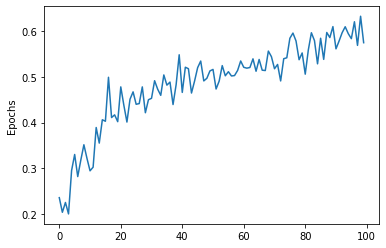

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc_test)
plt.ylabel('Test Accuracy')
plt.xlabel('Epochs')
plt.show()